<a href="https://colab.research.google.com/github/project-ccap/project-ccap.github.io/blob/master/notebooks/2020ccap_Foygel_Dell2000_2step_interactive_activaition_model_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulationf for the weight-decay and sp models
- date: 2020-1105
- author: Shin Asakawa
- Origin: Foygel and Dell (2000) Models of Impaired Lexical Access in Speech Production, 
- Journal of Memory and Language 43, 182–216 (2000) doi:10.1006/jmla.2000.2716

<center>
<img src="https://github.com/project-ccap/project-ccap.github.io/blob/master/figures/2000Foygel_Dell_fig1.png?raw=truen" style="width:33%"><br/>
    <div align="left" style="width:49%">
    Foygell and Dell (2000) Fig. 1. オリジナルは Dell (1997) 3 つの層の結合は双方向。
    上から意味層, 語彙層, 音素層。最上層の意味層で 暗く塗りつぶされているニューロンは `cat`, `dog`, `rat` で共有されていることを示す。
    </div>
</center>

Dell らのモデルには解析解が存在するのではないかという疑惑がある。
Dell らと Roelofs, Levelt らも基本的な動作方程式は上式の通りである。

$$
x_{i,t+1} = (1-d) x_{i,t} + \sum_j w x_{j,t} +\mathcal{N}(x_i),
$$

$x_{i,t}$ は時刻 $t$ における $i$ 番目のニューロンの活性値，$d$ は崩壊率，$w$ は重み係数である。
正規乱数であり $a_1=0.01, a_2=0.16$ をパラメータとする次式 $\mathcal{N}(x_i)\sim \mathcal{N}(0, a_1^2+a_2^2x_{i,t})$ 
で与えられる。
Dell の初期の weight decay モデルでは $w$ と $d$ が系全体の挙動を定めるパラメータであった。

<!--
ただし，Levelt, Roelofs らの WEAVER, WEAVER++, WEAVER++/ARC は決定論的動作方程式であるため，右辺最終稿の $\text{noise}$ が存在しない。

$1\le d\le0$ であるから，ノイズを無視すれば，

$$
x_{i,t} = e^{-dt},
$$
である。ノイズ項は乱数であるから，各乱数が i.i.d であると考えられるので，よく知られているとおり 2 つの確率変数 $x$ と $y$ の和の期待値と分散は
$$
E(X+Y) = E(X) + E(Y)
$$
$$
V(X+Y) = V(X) + V(Y) + \text{Cov}(X,Y)
$$
である。
-->

また $t=8$ のとき $x_{i,t=8}=10$ という，正解へのブースト (原著論文では `jolt`)がある。
$n=8$ と $n=16$ で jolt (boost) する。

- **レンマアクセス** 
猫の絵が提示されたとする。モデルの外にある視覚的プロセスが画像を識別し、猫の概念に対応する10個の意味的ノードにそれぞれ活性化の衝撃が与えられる。このときの衝撃の大きさは任意に100とし、10個のノードで分割すると、猫の意味ノードに10の衝撃が与えられることになる。
ネットワーク内にフィードバックが存在するということは、レンマアクセスの間に、`mat`, `sat`, `can` などの `cat` の音韻的隣接単語ノードが活性化されることを意味する。
これは `dog` のような意味的隣接語に加えて、共有された意味的なノードを介して活性化される。
したがって、このステップで最も活性化される単語ノードは、ターゲット語とその意味的・形式的に関連する隣接語人である。
レンマ・アクセスは、選択プロセスによって終了する。単語は、その中で最も活性化している単語ノードが選択される。

- **音素学的アクセス**
語彙検索の第二段階は、選択された単語のノードである `cat` に大きな活性化のブーストが与えられて開始される。
ブースト値は意味レベルへの最初のブーストと同様100単位である。
選択された単語へのこの大きなブーストは、非線形性が介入し、単語ノードが有用な隠れ層として機能することを可能にする。
これにより、意味層から単語形式への写像が実現される。
このブーストは、音韻的アクセスの開始時に、単語ノード `cat` をその競合単語のどれよりもはるかに活発にさせる。
`cat` へのブースト後、活性化はさらに $n$ 時間ステップ拡散する。
レンマアクセスの場合と同様、活性化は上にも下にも広がり `cat` に接続されているノード以外のノードが活性化することもある。
しかし、音素アクセス時の拡散処理の目的は `cat` の音素を取得することである。
$n$ 時間ステップを経て、最も活性化度の高い音素ノードが選択され、音韻フレームのスロットにリンクされる。
音素フレームは単語の構造を表しており、その音節の数とストレスパターン、各音節内の子音と母音の系列を表している。
本実装モデルにおける単純化では、単音節単語である，ｌ子音-母音-子音 (cvc) 単語のみを用いている。
各音素ノードは，オンセット子音と，母音と，コーダ子音 でラベル付けされる。
最も活性化度の高いオンセット，母音，コーダが選択され，フレーム内の対応するスロットに関連付けることで行われる。
`cat` の場合、/k/-オンセット, /ae/-母音, /t/-コーダのノードが選択されやすい。
モデルには 5 つのエラーカテゴリが存在する。
このエラーカテゴリは、コード化されることがあるいくつかの影響を反映してはいない。
例えば ターゲット単語の音素が誤って並べられる **言い間違いエラー**や、以前に話された単語やその音が対象語に持続的に入ってくる **保続エラー**である。
このモデルでは、スロット位置への音素の関連性を仮定しているため、音節内の音の並び替えを許容していない。

- **実装**
モデルを 非失語症患者の絵画命名検査結果に適合させ、その後、失語症患者データに再適合させる。
この実装のために、ネットワーク構造と拡散活性化パラメータの両方を指定しなければならない。
実装戦略は 3 つのフェーズからなる。
    - 第一段階: ネットワーク構造を特定し、モデルのネットワークが適用されるドメインである英語辞書の本質的な特徴を保持していることを確認する。
    - 第2段階: フィラデルフィア命名テスト（PNT）で英語の非形容詞話者をテストし、結果として得られる誤差データに適合するようにモデルをパラメータ化する。
    - 最終段階: パラメータ化されたモデルを患者データに適用する。
誤りの頻度を推定するため，非単語の頻度，すなわち生成された音列が非単語である可能性を決定した。
Dell and Reich (1981) と Best (1996) は、絵画命名研究と音声エラーから単語のセットを取り出し、各単語に含まれる 1 つの音素を別の音素で置き換えて、合法的な文字列を作成した。
これらセットに含まれる非単語の割合は 約 0.55 から 0.80 の範囲であった。
この場合、単語性とは大学レベルの辞書に掲載されていることを意味する。
この手法は、実際の単語の音素学的に合致した隣接非単語である確率を決定する。
しかし、この手法は実在する単語の隣接語を見ることになり、また、単語は音韻空間周辺に存在する傾向がある。
このため，非単語の結果のエラーの可能性を過小評価する可能性がある。
このため、非単語の誤差頻度の推定値として，最も保守的な値である $0.80$ を選択した。
また PNT の対象語に対して置換法を用いたところ、辞書基準を用いて $0.74$ の非単語が推定された。
このことから $0.80$ の値が妥当であることがわかった。

- **健常データへのフィット**
前述の近傍構造を用いて、統制群データに適合するモデルのパラメータ空間を探索した。
選択したパラメータは，データに近い誤差確率をもたらした。表は、これらのパラメータと 100,000 回の試行に基づいてシミュレートされた誤差確率を示している。
データとモデルの両方において、命名は非常に正確で、意味エラーが優勢であり、形式エラーは意味的な関係に関連してのみ存在していた。

<center>
Table 4: Nammg Data From 60 Control Participants and Simulated Probabilities

|Data source| correct | semantic | Formal | Non word | Mixed | Unrelated |
|-----------|---------|----------|--------|----------|-------|-----------|
|Controls   | .969    |.012      | .001   | .000     | .009  |  .003     |
|Simulated probabilities | .966 | .021 | .000 | .001 | .012  |  .000     |

Chosen parameters: $w=0.01$, $d=0.5$, $\text{SD1}=O.01$, $\text{SD2}=0.16$; $n=8$.
</center>

<!--
> **Lemma access**. Assume that a picture of a cat is presented. Visual processes that are outside of the model identify the picture
and the 10 semantic nodes corresponding to the cat concept are each given a jolt of activation. 
The size of the jolt was arbitrarily set at 100, which, when divided among 10 nodes, gives a jolt of 10 to each semantic node for cat.

> The existence of feedback in the network means that during lemma access the word nodes of phonological neighbors of _cat_, such as _mat_, _sat_, or _can_, will become activated. 
This is in addition to semantic neighbors such as _dog_, which obtain activation from shared semantic nodes. 
Thus, the most activated word nodes at this step are the target and its semantic and formally related neighbors.

> Lemma access is concluded by a selection process. 
The most highly activated word node of the proper syntactic category is selected. 
During the production of a sentence, selection entails the linkage of a word to a slot in a syntactic frame. 
Frame and slot approaches to grammatical encoding in production have ample empirical support (Bock & Loebell, 1990; Garrett, 1975; Levelt, 1989; see Bock & Levelt, 1994, for a review). 
In the case of object picture naming, we assume a degenerate frame consisting of a slot for a single noun. Therefore, in our implementation of the naming task, the most highly activated noun is selected.

> **Phonological access**. The second step of lexical retrieval begins when the selected word node. _cat_, is given a large jolt of activation. 
This is also 100 units' worth, the same as the initial jolt to the semantic level. 
When a sentence is being produced, the jolt to a word occurs when the syntactic frame says that it should occur. 
In a single-word naming task. 
it occurs immediately on selection because there is only a single noun slot in the frame.[3] 

> This large jolt to the selected word is important because it introduces a nonlinearity and hence allows the word nodes to act as a useful hidden layer. 
This, in turn, allows the meaning-to-form mapping to be achieved. 
The jolt makes the word node _cat_ much more active than any of its competitors at the beginning of phonological access. 
This function of enhancing the "winner" is often carried out by lateral inhibition among competitors (e.g., Feldman & Ballard, 1982; Grossberg, 1982; Harley, 1990; McClelland & Rumelhart, 1981) or by an absolute threshold that, when crossed, boosts the activation of a node (e.g., MacKay, 1987). 
The jolt to the selected word in our model is similar to these mechanisms. 
However, we are specifically tying it to syntactic processes. 
The source of the jolt is the syntactic slot that the selected word is linked to (e.g., Berg, 1988; Dell & O'Seaghdlha, 1991; Eikmeyer & Schade, 1991; MacKay, 1982, 1987; Stemberger, 1985).

> After the jolt to _cat_, activation spreads for $n$ more time steps. 
As was true for lemma access, adivation spreads both upward and downward, and nodes other than those connected to _cat_ can become activated. 
The goal of the spreading proccess during phonological access, however, is to retrieve the phonemes of _cat_. 
After the $n$ time steps, the most highly activated phoneme nodes are selected and linked to slots in a phonological frame, a process analogous to the linking of the selected word to a syntactic slot in lemma access. 
A phonological frame represents the structure of a word --- its number of syllables and their stress pattern and the sequence of consonants and vowels within each syllable. 
Most current theories of production hypothesize that phonological access consists of the retrieval of phoneme-size units and their insertion into frame slots, although there are differences among theorists with respect to the nature or the frame (for reviews, see Levelt. 1992; Meyer & Bock, 1992; Shattack-Hufnagel, 1992). 
The evidence for phonological frames comes from speech errors (e.g., Shattuck-Hufnagel, 1979; Sternberger, 1990) and experimental studies showing that frame structures can be primed (Meijer, 1994; Romani, 1992; Sevald, Dell, & Cole, 1995).

> One simplification of the implemented model is that it only has a frame for single-syllable consonant-vowel-consonant (cvc) words. 
Each phoneme node is labeled according to whether it is an onset consonant, a vowel, or a coda consonant.
Selection consists of picking the most highly activated onset, vowel, and coda and associating them with the corresponding slots in the frame. 
In the case of _cat_, the nodes for /k/-onset, /ae/-vowel, and /t/-coda would likely be seleted. 
Thus, phonological selection is guided by categoreies, such as onset or vowel, in the same way that lemma selection is guided by syntactic categories. 
Categorical selection in phonological access is suggested by patterns of sound substitutions in phonological speech
errors (e.g., MacKay, 1970, 1972; Shattuck-Hufnagel, 1979).


> Although the model's five error categories can code most of the error responses reported in the literature, the categories do not reflect some influences that are sometimes coded. 
These influences are observed in errors in which the phonemes of the target word are misordered and errors in which previously spoken  words or their sounds perseverate into the target. 
Because of the model's assumptions about the association of phonemes to slot positions, it does not allow for the misordering of sounds within a syllable, such as cat spoken as _act_ or _tack_. 
This is probably correct for normal speech errors (e.g., Dell, 1986), but not for aphasic speakers, who, as noted earlier, do exhibit misordering within the syllable or word. 
In addition, because the model assumes that each naming attempt is independent of other attempts, perseverative effects do not occur.
In principle, a spreading activation model can account for such effects through persistence of activation or connection weight changes (Plaul & Shallice, 1993a), but we did not implement such a mechanism.

保続についても言及はしているな

> **Implementation**. 
Our goal is to fit the model to nonaphasic picture-naming data and then lesion it to fit patient data. 
For such an implementation, both the network structures and the spreading activation parameters have to be specified. 
Our strategy for implementation has three phases. 
In the first phase, we specify the network structure, making sure that the model's network preserves essential features of the domain to which it is applied, the English lexicon. 
The second phase consists of testing nonaphasic speakers of English on the Philadelphia Naming Test (PNT) and then parameterizing the model so that it fits the resulting error data. 
The chosen parameters also will have to be consistent with facts about the time course of picture naming, specifically that the activation pattern initially includes semantic, but not phonological, neighbors of the target and then later includes phonological, but not semantic, neighbors (Peterson & Savoy, in press; Schriefers et al., 1990). 
The final phase of modeling involves applying the parameterized model to patient data. 

一段落省略

> To estimate the error opportunities, we first determined the opportunities for non words (i.e., the likelihood that a legal string is a nonword). 
Dell and Reich (1981) and Best (1996) took sets of words from picture-naming studies and speech error collections and replaced a single phoneme in each word with another phoneme creating a legal string. 
The proportion of nonwords in these sets ranged from around .55 to .80, in which wordhood meant being listed in a college-level dictionary. 
This technique essentially determines the chance that phonologically legal neighbors of real words are nonwords. 
However, because it involves looking at the neighbors of real words, and words tend to clump in phonological space, it may underestimate the error opportunities for nonword outcomes. 
For this reason, we chose the most conservative value, $0.80$, as the estimated error opportunity for nonwords. 
We also used the substitution technique on the target words for the PNT and found an estimate of $0.74$ nonwords using the dictionary criterion, which made us feel reasonably comfortable with the chosen $0.80$ value.

> #### Model Fit to Control Data 
> Using the neighborhood structure described earlier, we explored the parameter space of the model to fit the control data. 
The chosen parameters led to error probabilities reasonably close to those in the data. 
Table 4 shows these parameters and the simulated error probabilities, which were based on 100,000 trials. 
In both the data and the model, naming was highly accurate, semantically related errors predominated, and formal relations were present only in conjunction with a semantic relation. 

Table 4: Nammg Data From 60 Control Participants and Simulated Probabilities

|Data source| correct | semantic | Formal | Non word | Mixed | Unrelated |
|-----------|---------|----------|--------|----------|-------|-----------|
|Controls   | .969    |.012      | .001   | .000     | .009  |  .003     |
|Simulated probabilities | .966 | .021 | .000 | .001 | .012  |  .000     |

Chosen parameters: $w=0.01$, $d=0.5$, $SD1=O.01$, $SD2=0.16$; $n=8$.
-->

# 0. 初期設定

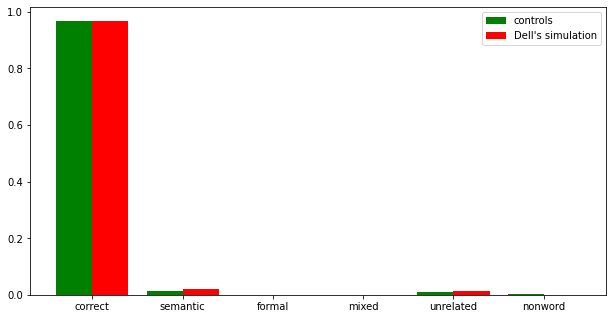

In [ ]:
import numpy as np
import time

from numpy.random import Generator, PCG64
#rng = Generator(PCG64())
#rng.standard_normal()

# 表示精度桁数の設定
np.set_printoptions(suppress=False, formatter={'float': '{:7.4f}'.format})

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
X = np.arange(6)

# Dell の結果を描画
controls = np.array([0.969, 0.012, 0.001, 0.000, 0.009, 0.003])
dells_results = np.array([0.966, 0.021, 0.000, 0.001, 0.012, 0.000])
ax.set_xticklabels(['', 'correct', 'semantic','formal','mixed','unrelated', 'nonword'])
ax.bar(X-0.2, controls, color='g', width=0.4, label='controls')
ax.bar(X+0.2, dells_results, color='r', width=0.4, label='Dell\'s simulation')
plt.legend()


# 1. 必要となるパラメータの宣言

In [ ]:
# Weight-Decay モデルのパラメータ
Weight = 0.1  # for normal
Decay  = 0.5  # for normal

# ノイズパラメータ。SD1 は定常雑音，SD2 は x の大きさに依存した雑音 N~(0,SD1^2+SD2^2 x)
SD1 = 0.01
SD2 = 0.16

# 外部入力を表す値，ブースト
sem_jolt = 10
lex_jolt = 100

# 3 層の 2 ステップ相互活性化モデルのニューロン数，意味層 <---> 語彙層 <---> 音韻層
n_sem = 57 # nubmer of semantic neurons
n_lex = 6  # number of lexical neurons
n_phon = 9 # number of phonological neurons

# 3 つの層の定義
Sem = np.zeros([n_sem,], dtype=np.float)   # 意味層
Lex = np.zeros([n_lex,], dtype=np.float)   # 語彙層
Pho = np.zeros([n_phon,], dtype=np.float)  # 音韻層

# cat(correct), dog(semantic), mat(formal), rat(mixed), log(unrelated), lat(nonword)
words = ['cat', 'dog', 'mat', 'rat', 'fog', 'lat']

# 意味層での語彙表現は 10 ニューロンが 1 で他が 0 であるので，そのことを表す全要素が 1 であるベクトル
input_vec = np.ones((1,10), dtype=np.float)   

W_s = np.zeros((n_lex, n_sem), dtype=np.float)  # 意味層 <--> 語彙層の結合係数行列
W_s[0,:10]   = np.copy(input_vec)  # `cat`
W_s[1,7:17]  = np.copy(input_vec)  # `dog`
W_s[2,17:27] = np.copy(input_vec)  # `mat`
W_s[3,27:37] = np.copy(input_vec)  # `rat`
W_s[4,37:47] = np.copy(input_vec)  # `fog`
W_s[5,47:]   = np.copy(input_vec)  # `lat`

W_p = np.zeros((n_lex, n_phon), dtype=np.float)  # 語彙層 <--> 音韻層の結語係数行列
phonemes = {'onset':['f', 'r', 'd', 'k', 'm'],
            'vowel':['ae', 'o'],
            'coda':['t','g']}
phonology = {}
for i, word in enumerate(words):
    Pho.fill(0)
    base = 0
    for phoneme, triplet in zip(word, phonemes.keys()):
        if phoneme == 'c':
            phoneme = 'k'
        if phoneme == 'a':
            phoneme = 'ae'
        if phoneme == 'l':
            phoneme = 'r'
        if phoneme in phonemes[triplet]:
            x = base + phonemes[triplet].index(phoneme)
            Pho[x] = 1
            W_p[i,x] = 1.
        base += len(phonemes[triplet])

    phonology[word] = np.copy(Pho)

Onset = slice(0,5)
Vowel = slice(5,7)
Coda = slice(7,9)

#for word in words:
#    print(word, end=' ')
#    for r in [Onset, Vowel, Coda]:
#        print(phonology[word][r], end=',')
#    print()

W_p *= Weight
W_s *= Weight



In [ ]:
def update_network(Sem, Lex, Pho, decay=Decay, sd1=SD1, sd2=SD2):
    """3 層を更新式を用いて更新する"""
    Sem_next = Sem * (1. - decay) + np.matmul(W_s.T, Lex)
    Lex_next = Lex * (1. - decay) + np.matmul(W_s, Sem) + np.matmul(W_p, Pho)
    Pho_next = Pho * (1. - decay) + np.matmul(W_p.T, Lex)
    
    # ノイズの付加
    for x in [Sem_next, Lex_next, Pho_next]:
        """SD1 ノイズの付加"""
        x +=  rng.standard_normal(size=len(x)) * sd1
        for i, xx in enumerate(x):
            """SD2 ノイズの付加と ReLU"""
            xx += xx * rng.standard_normal() * sd2
            x[i] = max(0,xx)
    return Sem_next, Lex_next, Pho_next


def run_one_epoch(Sem, Lex, Pho, n=16, jolt=10, jolt_t=7, verbose=False):
    
    # 各層を初期化
    Sem.fill(0); Lex.fill(0); Pho.fill(0)
    Sem[:10] = np.copy(input_vec)  # ターゲットである `cat` を意味層にセット
    #Sem[10:20] = np.copy(input_vec)  # dog にするならこの行を生かして直上行をコメントアウト

    # 更新は 16 回。原著論文では n と記載されている
    # t=8 のときブースト (jolt) を起こす
    Sem_next, Lex_next, Pho_next = Sem, Lex, Pho
    for tau in range(n):
        Sem_next, Lex_next, Pho_next = update_network(Sem_next, Lex_next, Pho_next)
        if verbose:
            print('tau=', tau+1, Lex_next)

        if tau == jolt_t:
            Lex_next[np.argmax(Lex_next)] = jolt

    # 最も良く当てはまっている出力を検索
    Sem, Lex, Pho = Sem_next, Lex_next, Pho_next
    min_v = np.finfo(Pho.dtype).max
    min_n = len(words) + 1
    for k, v in phonology.items():
        _x = np.mean((v - Pho)**2)
        if _x < min_v:
            min_n = k
            min_v = _x
    if min_n != 'cat':  # and verbose:
        print('{2:03d} output:{0}, Least Mean Square:{1:8.5f}'.format(min_n, min_v, i), end=", ")
        print('Pho', Pho)

    return min_n, min_v

In [ ]:
# フィラデルフィア絵画命名検査 PNT の図版総数が 175 枚であるため，この回数だけ繰り返す
nPNT = 175
#nPNT = 3  # テスト用

seed = int(time.time())
#seed = 20201227
rng = Generator(PCG64(seed))

verbose = False
jolt = 10
jolt_t = 7  # カウントが 0 ベースなので t=7 (8-1) が 8 回目

results = np.zeros((nPNT, len(words)), dtype=np.float)
for i in range(nPNT):

    min_n, min_v = run_one_epoch(Sem, Lex, Pho, verbose=False)
    results[i, words.index(min_n)] = 1.
    
print('response', words)
print('result: ', np.mean(results,axis=0))
print('control:', controls)
    

In [ ]:
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
X = np.arange(6)

ax.set_xticklabels(['', 'correct', 'semantic','formal','mixed','unrelated', 'nonword'])
ax.bar(X-0.2, controls, color='g', width=0.4, label='controls')
ax.bar(X+0.2, np.mean(results,axis=0), color='r', width=0.4, label='simulated')
plt.legend()
